In [7]:
import os
data_dir = 'Model Data'

import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from kerastuner.tuners import Hyperband

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
long_data1 = pd.read_csv(os.path.join(data_dir, 'long_data1.csv'), index_col=0)

In [11]:
def create_grouped_dataset(data, n_time_steps=7, feature='count'):
    grouped_data = []
    grouped_labels = []
    group_ids = data['group_id'].unique()

    for group in group_ids:
        group_data = data[data['group_id'] == group][feature].values
        for i in range(len(group_data) - n_time_steps + 1):
            grouped_data.append(group_data[i:i + n_time_steps])
            grouped_labels.append(group_data[i:i + n_time_steps])

    return np.array(grouped_data), np.array(grouped_labels)

In [12]:
# feature selection
feature = 'count'
data = long_data1[['time_step', 'group_id', feature, "treatment", "agegrp", "sex", "oud"]]

# sort by group_id and time_step
data = data.sort_values(by=['group_id', 'time_step'])

# we have 7 time point in this data set
n_time_steps = 7
X, y = create_grouped_dataset(data, n_time_steps, feature)

# reshape data
X = X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(y.shape[0], y.shape[1])

# scale the data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_train = scaler_X.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y_train = scaler_y.fit_transform(y)

In [13]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_base', min_value=32, max_value=256, step=32),
                   activation=hp.Choice('activation_base', values=['relu', 'tanh', 'sigmoid']),
                   return_sequences=True, 
                   input_shape=(n_time_steps, 1)))
    
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid']),
            return_sequences=True))
    
    model.add(LSTM(units=hp.Int('units_final', min_value=32, max_value=256, step=32),
                   activation=hp.Choice('activation_final', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(n_time_steps))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


In [ ]:
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=200,
    factor=3,
    directory='hyperband_search',
    project_name='lstm_tuning')

In [15]:
tuner.search(X_train, y_train, epochs=200, validation_data=(X_train, y_train))

best_model = tuner.get_best_models(num_models=1)[0]

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hyperparameters.values}")

Trial 254 Complete [03h 28m 37s]
val_loss: 0.007067888509482145

Best val_loss So Far: 3.5989630760013824e-06
Total elapsed time: 2d 03h 20m 33s
Best hyperparameters: {'units_base': 256, 'activation_base': 'relu', 'num_layers': 1, 'units_0': 256, 'activation_0': 'tanh', 'units_final': 224, 'activation_final': 'tanh', 'units_1': 192, 'activation_1': 'relu', 'units_2': 128, 'activation_2': 'tanh', 'units_3': 192, 'activation_3': 'sigmoid', 'units_4': 128, 'activation_4': 'tanh', 'units_5': 32, 'activation_5': 'tanh', 'units_6': 96, 'activation_6': 'relu', 'units_7': 192, 'activation_7': 'sigmoid', 'units_8': 96, 'activation_8': 'relu', 'units_9': 256, 'activation_9': 'sigmoid', 'tuner/epochs': 200, 'tuner/initial_epoch': 67, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0142'}


In [ ]:
best_model.save('best_model.h5')

In [ ]:
def fit_model(model, X_train, y_train, scaler_y, epochs=200, initial_epoch=10, batch_size=32, validation_data=None, fit=True):
    history = None
    fit_time = None
    
    if fit:
        start_time = time.time()
        history = model.fit(X_train, y_train, epochs=epochs, initial_epoch=initial_epoch, batch_size=batch_size, validation_data=validation_data, verbose=1)
        end_time = time.time()
        fit_time = end_time - start_time
    
    train_predict = model.predict(X_train)
    
    train_predict = scaler_y.inverse_transform(train_predict)
    return history, train_predict, fit_time

model = load_model('best_model.h5')
model.summary()
history, train_predict, fit_time = fit_model(model, X_train, y_train, scaler_y, epochs=200, initial_epoch=0, batch_size=32, validation_data=(X_train, y_train), fit=False)

In [37]:
print(fit_time)

733.4378037452698


# Evaluate Model

In [57]:
def model_rmse(y_train, train_predict):
    y_small_index = np.where(y_train < 200)[0]
    y_large_index = np.where(y_train >= 200)[0]
    y_train_samll= y_train[y_small_index]
    y_train_large = y_train[y_large_index]
    
    train_predict_samll = train_predict[y_small_index]
    train_predict_large = train_predict[y_large_index]
    
    train_score_full = math.sqrt(mean_squared_error(y_train, train_predict))
    train_score_small = math.sqrt(mean_squared_error(y_train_samll, train_predict_samll))
    train_score_large = math.sqrt(mean_squared_error(y_train_large, train_predict_large))
    
    print(f'RMSE for full data: {train_score_full:.2f}')
    print(f'RMSE for small count: {train_score_small:.2f}')
    print(f'RMSE for large count: {train_score_large:.2f}')
    
    return train_score_full, train_score_small, train_score_large

model_rmse(y, train_predict)
    

RMSE for full data: 15.62
RMSE for small count: 6.40
RMSE for large count: 40.88


(15.620350329658793, 6.401010495058592, 40.87666222949874)

In [52]:
def individual_predict(ids, x_scaler, y_scaler, model, data, n_time_steps=7, feature='count'):
    actual_vs_predicted = {}

    for group_id in ids:
        group_data = data[data['group_id'] == group_id][feature].values
        X_group = group_data[:n_time_steps].reshape(1, n_time_steps, 1)
        X_group = x_scaler.transform(X_group.reshape(-1, 1)).reshape(X_group.shape)
        
        start_time = time.time()
        predicted = model.predict(X_group)
        predicted = y_scaler.inverse_transform(predicted).flatten()
        end_time = time.time()
        predict_time = end_time - start_time

        actual_vs_predicted[group_id] = {
            "actual": group_data[:n_time_steps],
            "predicted": predicted,
            "predict_time": predict_time
        }

    return actual_vs_predicted

def plot_results(actual_vs_predicted, selected_group_ids, col_count=3):
    
    plot_count = len(selected_group_ids)
    n_rows = math.ceil(plot_count / col_count)
    n_cols = min(plot_count, col_count)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    if n_rows == 1:
        axs = np.expand_dims(axs, axis=0)
    if n_cols == 1:
        axs = np.expand_dims(axs, axis=1)

    for i, group_id in enumerate(selected_group_ids):
        actual_data = actual_vs_predicted[group_id]['actual']
        predicted_data = actual_vs_predicted[group_id]['predicted']
        time_steps = np.arange(len(actual_data))
        
        ax = axs[i // n_cols, i % n_cols]
        
        # Plot actual values
        ax.plot(time_steps, actual_data, label=f'RESPOND')
        ax.scatter(time_steps, actual_data, s=50)
        
        # Plot predicted values
        ax.plot(time_steps, predicted_data, linestyle='--', label=f'LSTM')
        ax.scatter(time_steps, predicted_data, s=50)
        
        ax.set_title(f'Group {group_id}')
        ax.set_xlabel('Time (by week)')
        ax.set_ylabel('Count')
        ax.legend()
        
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axs[j // n_cols, j % n_cols])
    
    plt.tight_layout()
    plt.show()

Draw samples from full data

In [ ]:
def calculate_changes(df):
    reference_count = df[df['time_step'] == 157]['count'].values[0]
    df['count_change'] = reference_count - df['count']
    df['data_split'] = 'small_change' if df['count_change'].abs().max() <= 200 else 'large_change'
    return df

change_data = long_data1.groupby('group_id').apply(calculate_changes)

large_change_id = change_data[change_data['data_split'] == 'large_change']['group_id'].unique()
small_change_id = change_data[change_data['data_split'] == 'small_change']['group_id'].unique()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


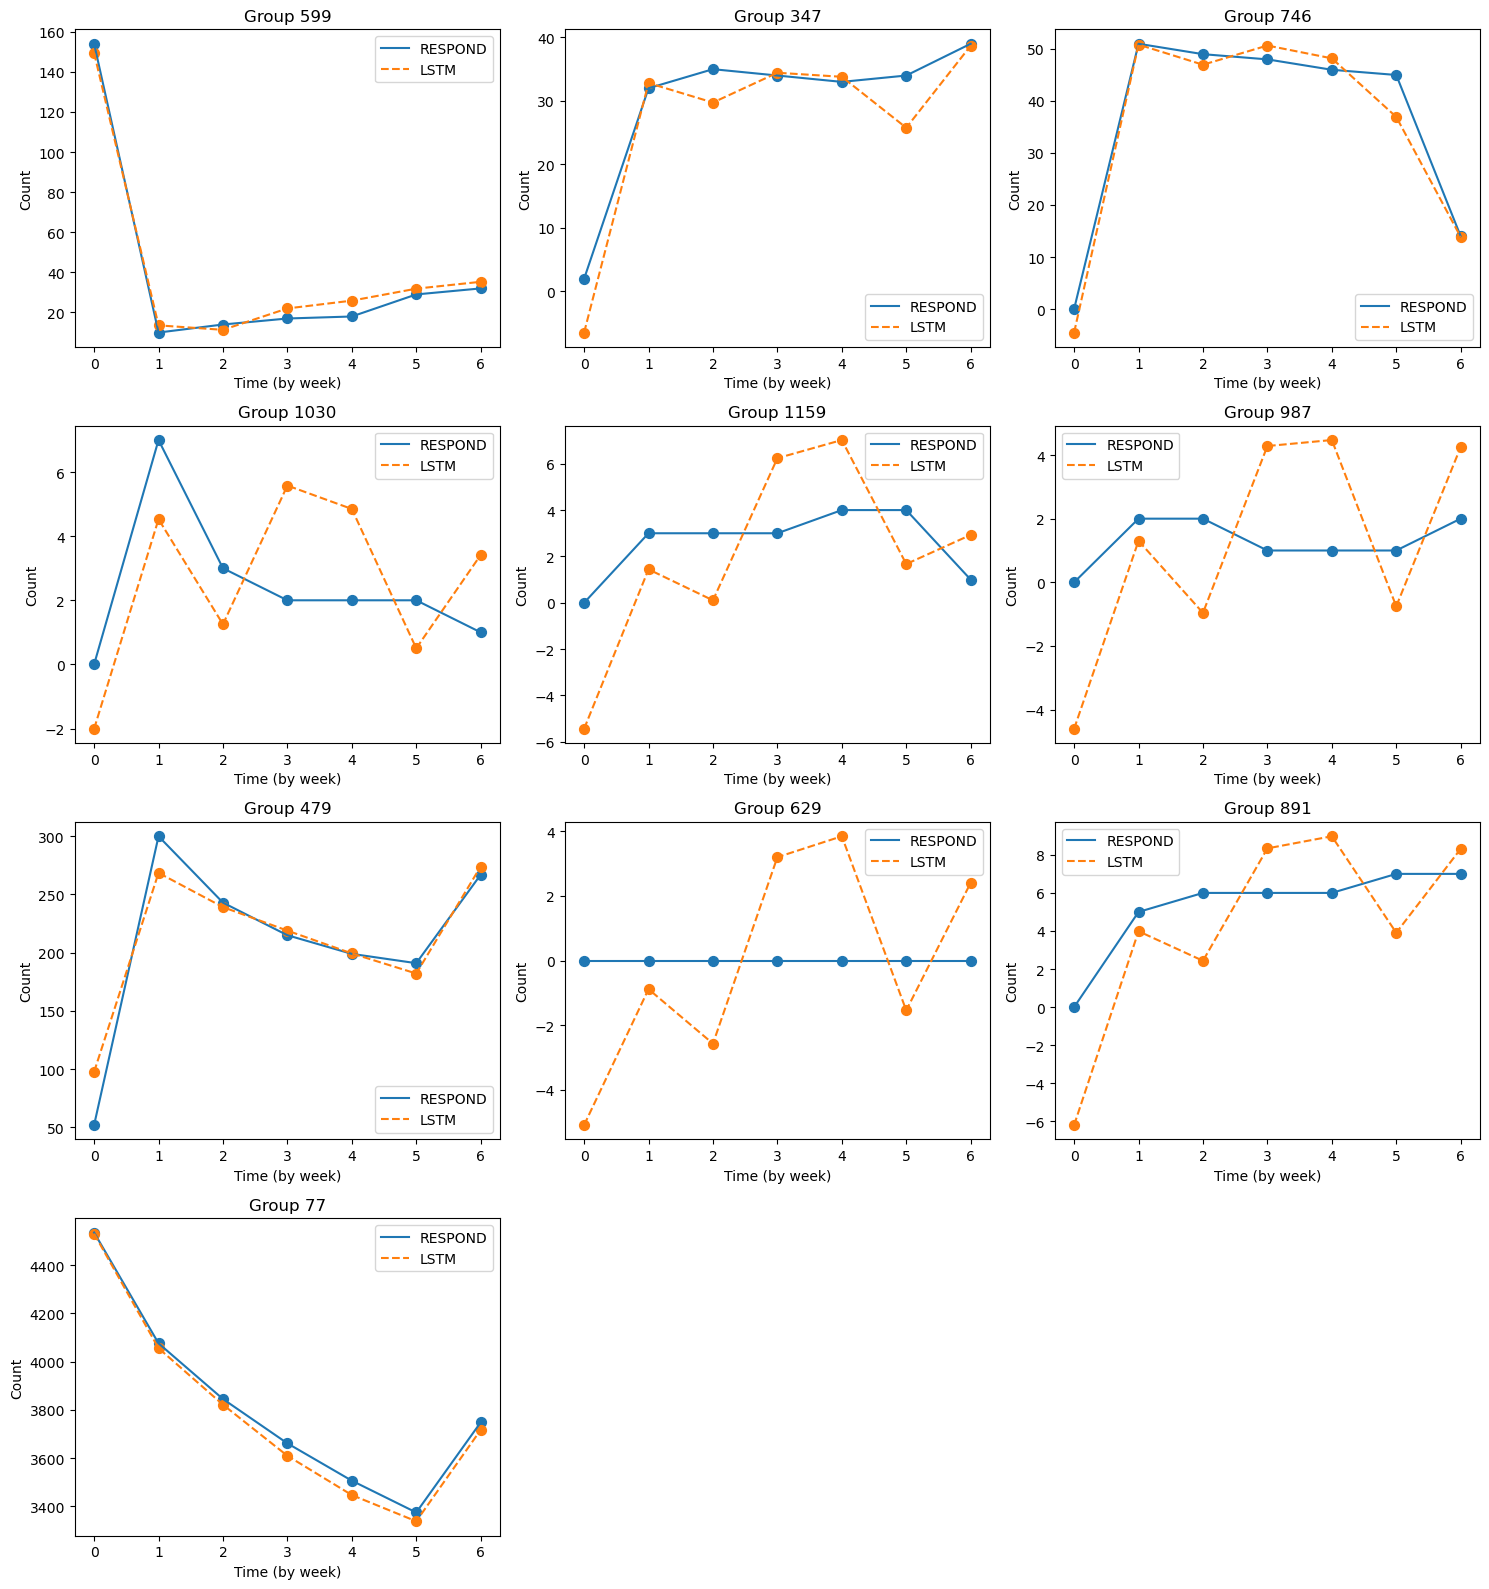

{599: {'actual': array([154,  10,  14,  17,  18,  29,  32]), 'predicted': array([149.43364 ,  13.576566,  11.347096,  22.014423,  25.905779,
        31.876785,  35.296215], dtype=float32), 'predict_time': 0.09722709655761719}, 347: {'actual': array([ 2, 32, 35, 34, 33, 34, 39]), 'predicted': array([-6.4614086, 32.818176 , 29.746708 , 34.43696  , 33.801594 ,
       25.778023 , 38.69705  ], dtype=float32), 'predict_time': 0.045269012451171875}, 746: {'actual': array([ 0, 51, 49, 48, 46, 45, 14]), 'predicted': array([-4.5236073, 50.840565 , 46.96814  , 50.6631   , 48.197704 ,
       36.938488 , 13.852169 ], dtype=float32), 'predict_time': 0.043237924575805664}, 1030: {'actual': array([0, 7, 3, 2, 2, 2, 1]), 'predicted': array([-2.008466  ,  4.530183  ,  1.2513322 ,  5.5791216 ,  4.8494253 ,
        0.50191426,  3.4144742 ], dtype=float32), 'predict_time': 0.043473005294799805}, 1159: {'actual': array([0, 3, 3, 3, 4, 4, 1]), 'predicted': array([-5.4364157 ,  1.44239   ,  0.10608691,  6.238

In [53]:
selected_group_ids = np.random.choice(data['group_id'].unique(), 10, replace=False)
actual_vs_predicted = individual_predict(selected_group_ids, scaler_X, scaler_y, model, data, n_time_steps, feature)

plot_results(actual_vs_predicted, selected_group_ids)

print(actual_vs_predicted)

Draw samples from small count data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


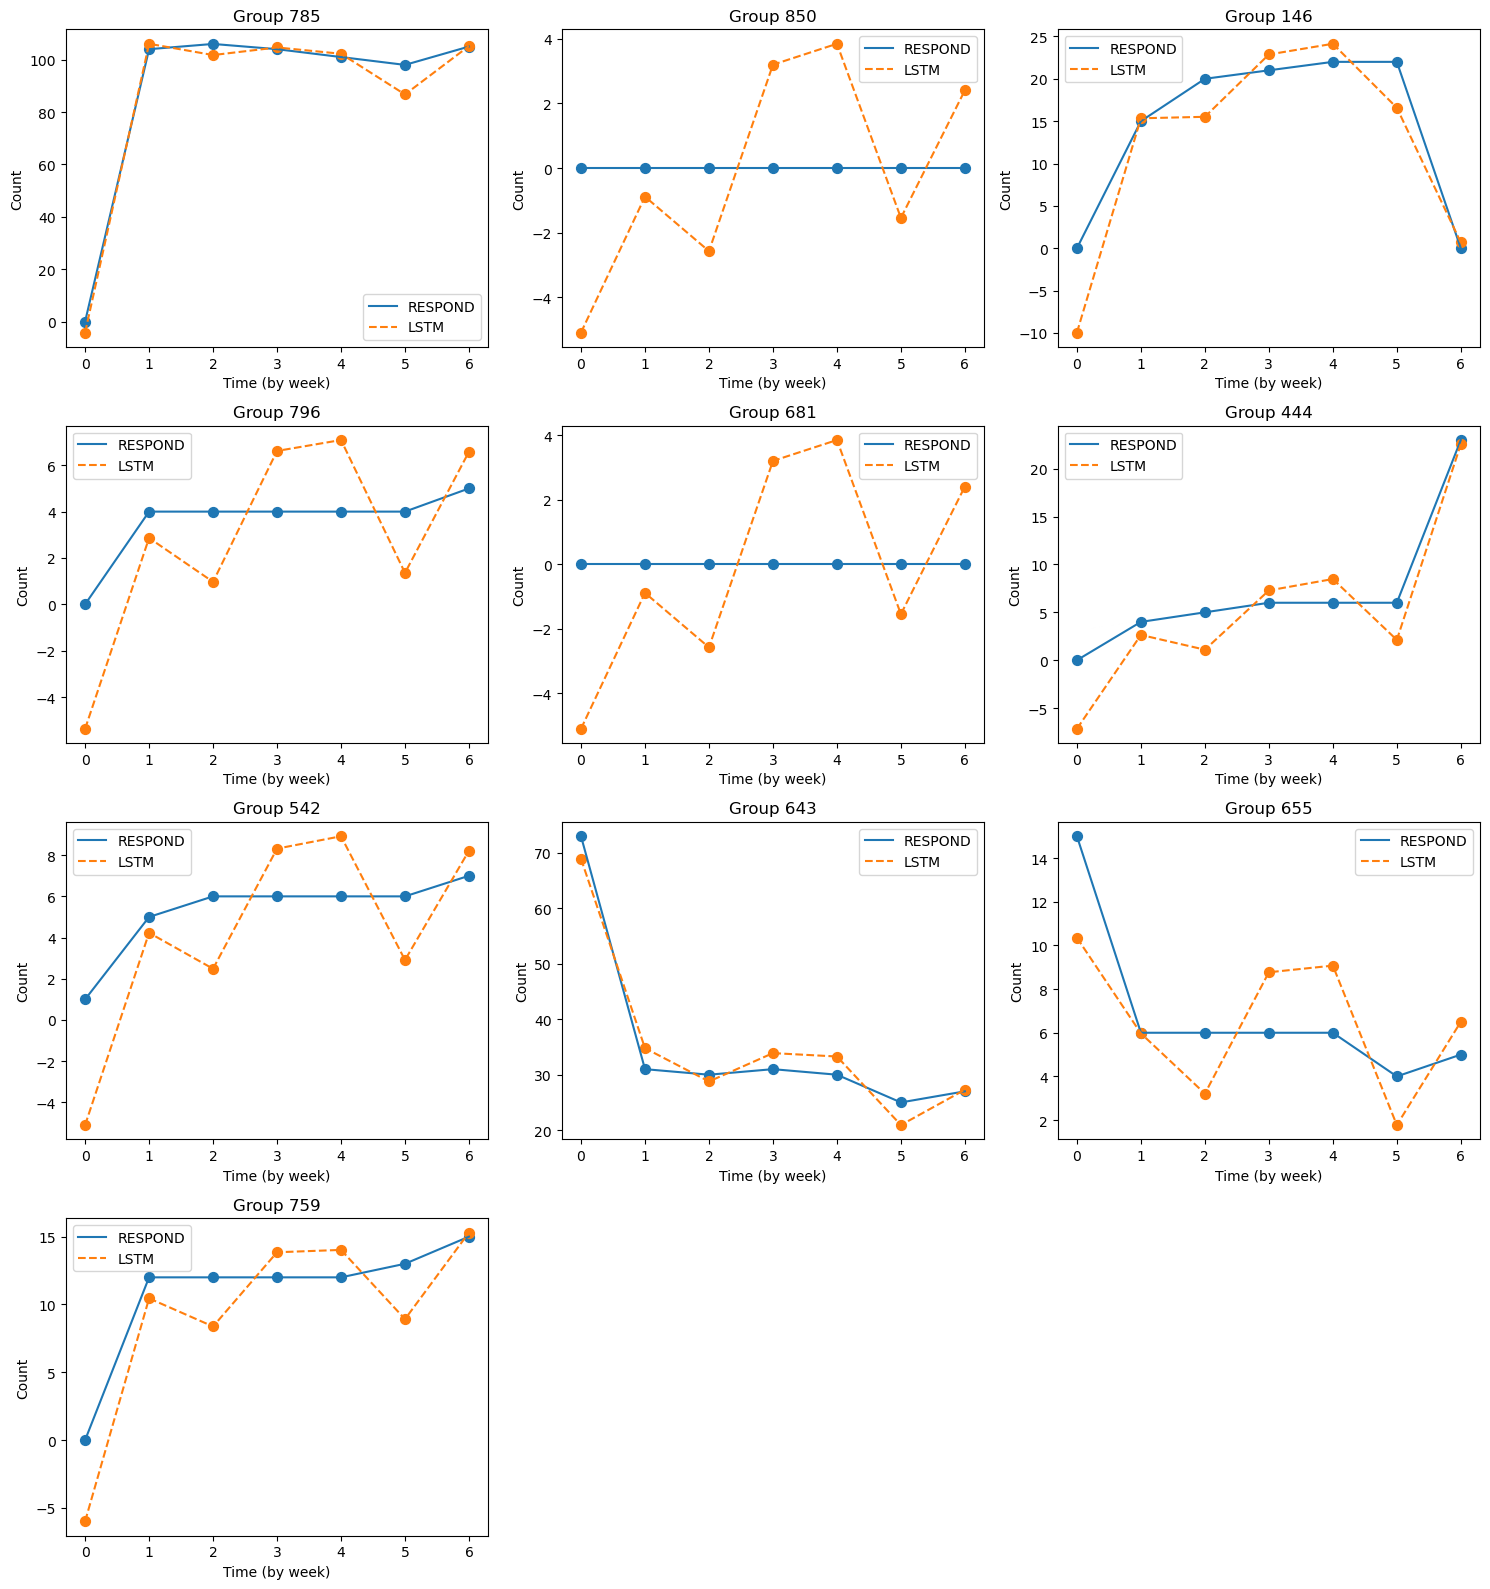

In [54]:
selected_group_ids_small = np.random.choice(small_change_id, 10, replace=False)
actual_vs_predicted = individual_predict(selected_group_ids_small, scaler_X, scaler_y, model, data, n_time_steps, feature)

plot_results(actual_vs_predicted, selected_group_ids_small)

Draw samples from large count data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


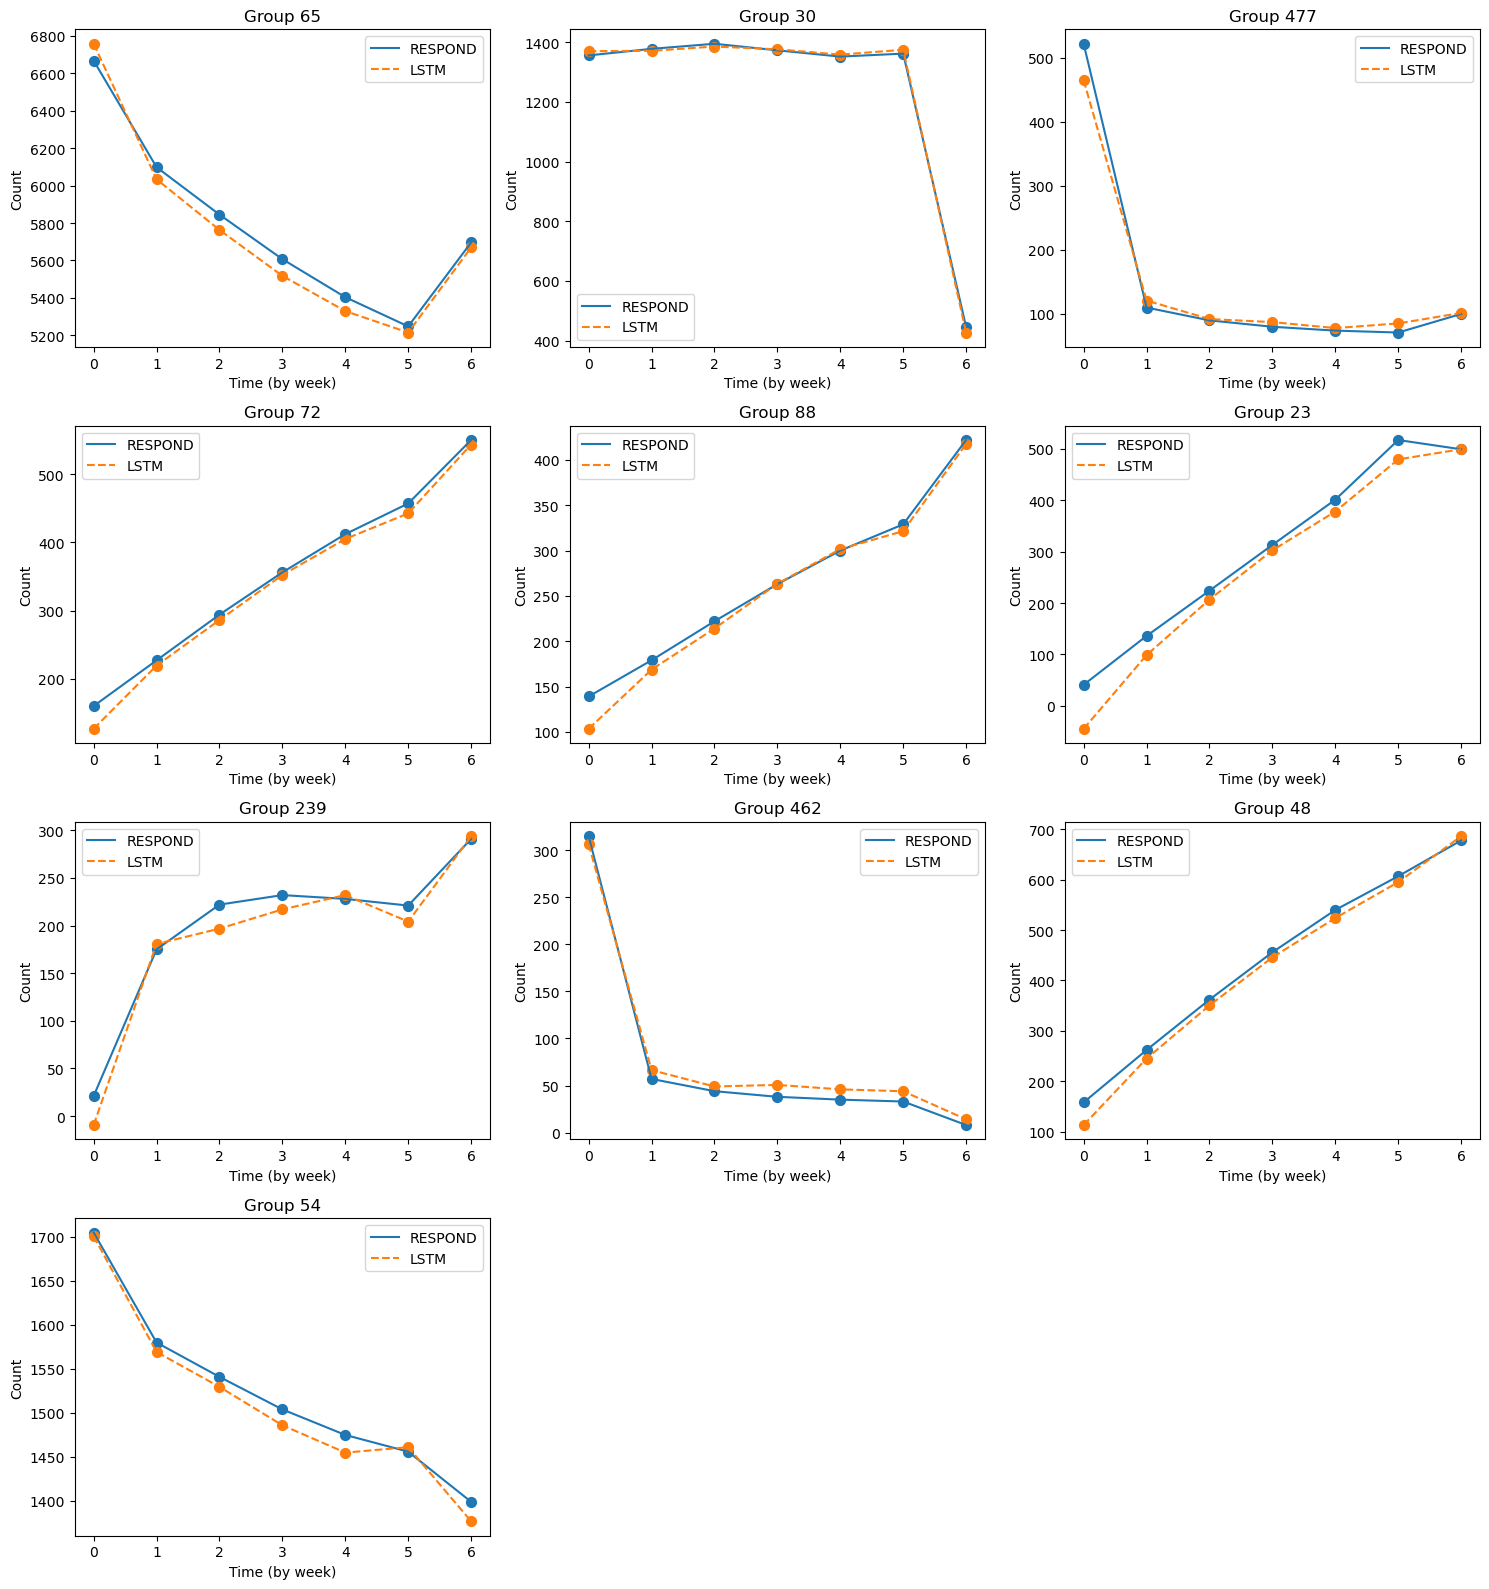

In [55]:
selected_group_ids_large = np.random.choice(large_change_id, 10, replace=False)
actual_vs_predicted = individual_predict(selected_group_ids_large, scaler_X, scaler_y, model, data, n_time_steps, feature)

plot_results(actual_vs_predicted, selected_group_ids_large)